# DBSCAN Clustering for TOSP Codes

This notebook will be covering the following:  

*   Preprocessing a dataset of procedure descriptions
*   Calculation of text similarities
*   Performing DBSCAN clustering
*   Identifying and visualizing clusters
*   Optimizing DBSCAN parameters

---

## **1. Import Libraries and Setup**

Importing the necessary libraries and downloading the required NLP resources.


In [7]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import itertools

# Download necessary NLP resources
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## **2. Load and Preprocess the Data**

Load the dataset, generate pairs of codes, and combine descriptions.


In [8]:
# Load the dataset
df = pd.read_csv("SL_Eye.csv")
print("Dataset loaded successfully.")

# Display first few rows
print(df.head())

# --- Preprocessing the text data ---
# 1. Tokenization, removing punctuation, and lowercasing
def preprocess_text(text):
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with single space
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.lower()  # Convert text to lowercase
    return text

# 2. Remove stopwords and lemmatization
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

def clean_description(description):
    tokens = description.split()  # Tokenization
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]  # Lemmatize and remove stopwords
    return ' '.join(tokens)

# Apply preprocessing to the descriptions
df['Cleaned_Description'] = df['Description'].apply(preprocess_text).apply(clean_description)

print("Sample Preprocessed Descriptions:")
print(df[['Code', 'Cleaned_Description']].head())

Dataset loaded successfully.
   S/N    Code                                        Description Table  \
0    1  SL800A  ANTERIOR CHAMBER PARACENTESIS, IRRIGATION OR R...    1B   
1    2  SL802A  ANTERIOR CHAMBER, VARIOUS LESIONS, VITREOUS RE...    3B   
2    3  SL700B              BROW, BROWLIFT, ENDOSCOPIC, BILATERAL    5A   
3    4  SL701B  BROW, BROWLIFT, ENDOSCOPIC, BILATERAL WITH MID...    5C   
4    5  SL702B             BROW, BROWLIFT, ENDOSCOPIC, UNILATERAL    4A   

  Classification  
0       Existing  
1       Existing  
2       Existing  
3       Existing  
4       Existing  
Sample Preprocessed Descriptions:
     Code                                Cleaned_Description
0  SL800A  anterior chamber paracentesis irrigation refor...
1  SL802A   anterior chamber various lesion vitreous removal
2  SL700B                 brow browlift endoscopic bilateral
3  SL701B   brow browlift endoscopic bilateral mid face lift
4  SL702B                brow browlift endoscopic unilateral


## **3. Generate Pairs of Codes**

Generate pairs of procedure codes for similarity comparison.


In [9]:
# Generate all possible pairs of codes
pairs = list(itertools.combinations(df['Code'], 2))

# Convert to DataFrame
pairs_df = pd.DataFrame(pairs, columns=['Code1', 'Code2'])

# Merge descriptions
pairs_df = pairs_df.merge(df[['Code', 'Cleaned_Description']], left_on='Code1', right_on='Code', how='left').rename(columns={'Cleaned_Description': 'Description1'}).drop(columns=['Code'])
pairs_df = pairs_df.merge(df[['Code', 'Cleaned_Description']], left_on='Code2', right_on='Code', how='left').rename(columns={'Cleaned_Description': 'Description2'}).drop(columns=['Code'])

print(pairs_df.head())

    Code1   Code2                                       Description1  \
0  SL800A  SL802A  anterior chamber paracentesis irrigation refor...   
1  SL800A  SL700B  anterior chamber paracentesis irrigation refor...   
2  SL800A  SL701B  anterior chamber paracentesis irrigation refor...   
3  SL800A  SL702B  anterior chamber paracentesis irrigation refor...   
4  SL800A  SL703B  anterior chamber paracentesis irrigation refor...   

                                       Description2  
0  anterior chamber various lesion vitreous removal  
1                brow browlift endoscopic bilateral  
2  brow browlift endoscopic bilateral mid face lift  
3               brow browlift endoscopic unilateral  
4                  brow direct browplasty bilateral  


## **4. Text Vectorization and Similarity Calculation**

Convert the cleaned descriptions to TF-IDF vectors and calculate cosine similarity.

In [10]:
# Combine all cleaned descriptions
descriptions = df['Cleaned_Description'].tolist()

# Convert text to TF-IDF features
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(descriptions)

# Standardize the TF-IDF matrix
tfidf_matrix_scaled = StandardScaler(with_mean=False).fit_transform(tfidf_matrix)

# Compute cosine similarity matrix
similarity_matrix = cosine_similarity(tfidf_matrix_scaled)

# Convert to a DataFrame for faster lookups
similarity_df = pd.DataFrame(similarity_matrix, index=df['Code'], columns=df['Code'])

# Function to fetch similarity scores efficiently
def get_similarity(code1, code2):
    return similarity_df.at[code1, code2]

# Apply the function efficiently
pairs_df['Similarity'] = pairs_df.apply(lambda row: get_similarity(row['Code1'], row['Code2']), axis=1)

print(pairs_df.head())

    Code1   Code2                                       Description1  \
0  SL800A  SL802A  anterior chamber paracentesis irrigation refor...   
1  SL800A  SL700B  anterior chamber paracentesis irrigation refor...   
2  SL800A  SL701B  anterior chamber paracentesis irrigation refor...   
3  SL800A  SL702B  anterior chamber paracentesis irrigation refor...   
4  SL800A  SL703B  anterior chamber paracentesis irrigation refor...   

                                       Description2  Similarity  
0  anterior chamber various lesion vitreous removal    0.302608  
1                brow browlift endoscopic bilateral    0.000000  
2  brow browlift endoscopic bilateral mid face lift    0.000000  
3               brow browlift endoscopic unilateral    0.000000  
4                  brow direct browplasty bilateral    0.000000  


## **5. Dimensionality Reduction (PCA + t-SNE)**

Use PCA for initial dimensionality reduction and then apply t-SNE for further reduction before clustering.

Explained Variance Ratio for each PCA component: [0.02737699 0.02230641 0.01945294 0.01908221 0.01686004 0.0167132
 0.01551515 0.01510231 0.01471032 0.01404352 0.01367918 0.01344216
 0.01341061 0.01303697 0.01278583 0.01270454 0.01226011 0.01194155
 0.01184273 0.0114186  0.01135728 0.0112683  0.01107842 0.0109128
 0.01084866 0.01080392 0.01068038 0.01065912 0.01037807 0.01021732
 0.01008613 0.00997195 0.00984116 0.00980484 0.00966856 0.00940244
 0.00937106 0.0093421  0.00919385 0.00912252 0.00886057 0.0086176
 0.00858722 0.00850207 0.00844145 0.00835952 0.00823018 0.00814806
 0.00813883 0.00809307]


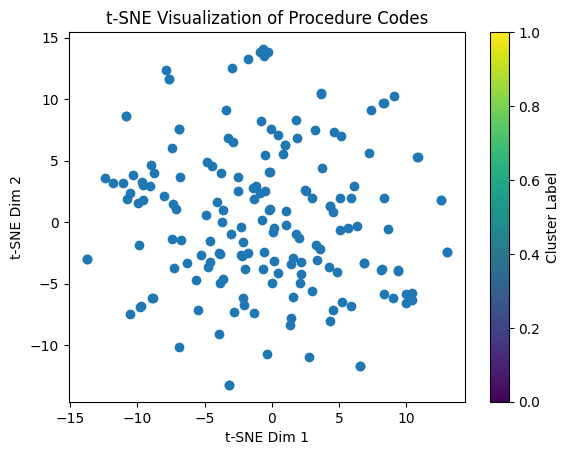

In [45]:
# --- Dimensionality Reduction using PCA ---
pca = PCA(n_components=50)  # Reduce to 50 dimensions for PCA
pca_components = pca.fit_transform(tfidf_matrix_scaled)

# Explained variance ratio (how much variance is explained by each PCA component)
print(f"Explained Variance Ratio for each PCA component: {pca.explained_variance_ratio_}")

# --- t-SNE for 2D visualization ---
tsne = TSNE(n_components=2, random_state=42)
reduced_vectors = tsne.fit_transform(pca_components)

# Plot t-SNE
plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1])
plt.colorbar(label="Cluster Label")
plt.title("t-SNE Visualization of Procedure Codes")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.show()

## **6. DBSCAN Clustering**

Perform DBSCAN clustering on the TF-IDF data after dimensionality reduction.

In [41]:
# Define the initial DBSCAN model
dbscan = DBSCAN(eps=0.19, min_samples=2, metric="cosine")  # Default parameters
labels = dbscan.fit_predict(pca_components)

# Check the silhouette score to evaluate clustering performance
silhouette = silhouette_score(pca_components, labels, metric='cosine')
print(f"Initial Silhouette Score: {silhouette}")

Initial Silhouette Score: 0.4142746784632138


## **7. Optimizing DBSCAN Parameters**

Optimize eps and min_samples based on silhouette scores and visualize the elbow curve to choose the best eps.

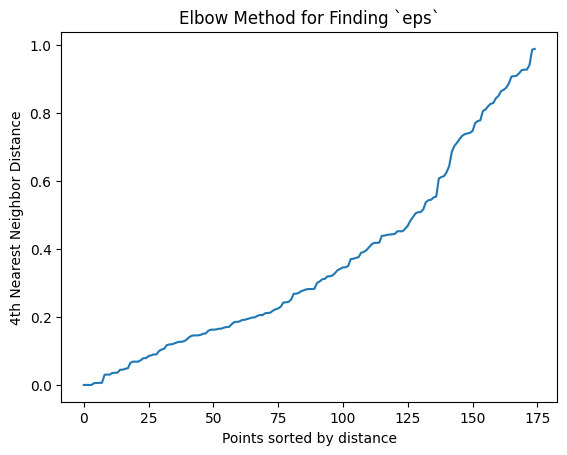

Best Silhouette Score: 0.4142746784632138 with eps = 0.19090909090909092 and min_samples = 2


In [42]:
# Use 4 nearest neighbors (rule of thumb for DBSCAN)
neighbors = NearestNeighbors(n_neighbors=4, metric="cosine")
neighbors_fit = neighbors.fit(pca_components)
distances, indices = neighbors_fit.kneighbors(pca_components)

# Sort and plot distances (4th nearest neighbor distance)
distances = np.sort(distances[:, -1])
plt.plot(distances)
plt.xlabel("Points sorted by distance")
plt.ylabel("4th Nearest Neighbor Distance")
plt.title("Elbow Method for Finding `eps`")
plt.show()

# Define a range of eps and min_samples values to test
eps_values = np.linspace(0.1, 1.0, 100)
min_samples_values = [2, 3, 4, 5, 6, 7]

# Function to calculate silhouette scores for parameter combinations
def find_best_dbscan_params(eps_values, min_samples_values, pca_components):
    best_score = -1
    best_params = (None, None)

    for eps in eps_values:
        for min_samples in min_samples_values:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric="cosine")
            labels = dbscan.fit_predict(pca_components)

            # Only calculate silhouette score if more than one cluster is formed (excluding noise)
            if len(set(labels)) > 1:
                score = silhouette_score(pca_components, labels, metric='cosine')
                if score > best_score:
                    best_score = score
                    best_params = (eps, min_samples)

    return best_score, best_params

# Find the best parameters
best_score, best_params = find_best_dbscan_params(eps_values, min_samples_values, pca_components)
print(f"Best Silhouette Score: {best_score} with eps = {best_params[0]} and min_samples = {best_params[1]}")

## **8. Visualizing Clusters**

Reduce the dimensions for better visualization and plot the clusters after DBSCAN.

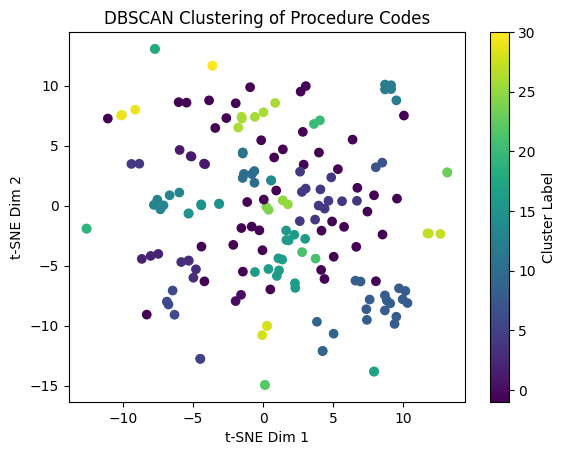

In [43]:
# Apply t-SNE for 2D visualization of DBSCAN clusters
tsne = TSNE(n_components=2, random_state=42)
reduced_vectors = tsne.fit_transform(pca_components)

# Plot clusters
plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c=labels, cmap='viridis')
plt.colorbar(label="Cluster Label")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.title("DBSCAN Clustering of Procedure Codes")
plt.show()

## **9. Identifying and Interpreting Clusters**

Analyze the resulting clusters and check for outliers.

In [44]:
# Add cluster labels to the original data
df['Cluster'] = labels

# Print cluster information
unique_clusters, counts = np.unique(df['Cluster'], return_counts=True)
print("Unique Clusters Found:", unique_clusters)
print("Cluster Counts:", dict(zip(unique_clusters, counts)))

# Display meaningful clusters (non-noise)
print(df[df['Cluster'] != -1].head())

# Optionally: Print a few codes in each cluster
for cluster in np.unique(df['Cluster']):
    print(f"\nCluster {cluster}:")
    print(df[df['Cluster'] == cluster][['Code', 'Description']].head(10))  # Show first 10 items

Unique Clusters Found: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30]
Cluster Counts: {-1: 45, 0: 2, 1: 5, 2: 3, 3: 5, 4: 14, 5: 2, 6: 4, 7: 2, 8: 15, 9: 4, 10: 5, 11: 2, 12: 5, 13: 6, 14: 2, 15: 6, 16: 13, 17: 2, 18: 2, 19: 2, 20: 2, 21: 2, 22: 2, 23: 2, 24: 2, 25: 2, 26: 6, 27: 3, 28: 3, 29: 3, 30: 2}
   S/N    Code                                        Description Table  \
0    1  SL800A  ANTERIOR CHAMBER PARACENTESIS, IRRIGATION OR R...    1B   
1    2  SL802A  ANTERIOR CHAMBER, VARIOUS LESIONS, VITREOUS RE...    3B   
2    3  SL700B              BROW, BROWLIFT, ENDOSCOPIC, BILATERAL    5A   
3    4  SL701B  BROW, BROWLIFT, ENDOSCOPIC, BILATERAL WITH MID...    5C   
4    5  SL702B             BROW, BROWLIFT, ENDOSCOPIC, UNILATERAL    4A   

  Classification                                Cleaned_Description  Cluster  
0       Existing  anterior chamber paracentesis irrigation refor...        0  
1       Existing   anterior chambe